# Segunda práctica de Aprendizaje Automático

Implementación del grupo 17, formado por:
- Sergio Barragán Blanco (100472343)
- Eduardo Alarcón Navarro (100472175)

# Lectura del fichero CSV


In [121]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import time
from sklearn.metrics import silhouette_score

# Carga de datos
def load_data():
    data = pd.read_csv('Stars2.csv')
    return data
data = load_data()


# A continuación, haremos nuestra propia implementación del Kmeans
Con el objetivo de, posteriormente, comparar nuestra implementación con la oficial de scikit-learn

In [122]:

class Kmeans():
    def __init__(self, n_clusters=8, max_iter=300, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = 343175
        self.cluster_centers_ = None
        self.labels_ = None

    def fit(self, X, y=None, sample_weight=None):
        # Inicialización de los centroides de manera aleatoria
        rng = np.random.default_rng(self.random_state)
        self.cluster_centers_ = rng.choice(X, size=self.n_clusters, replace=False)

        for _ in range(self.max_iter):
            self._assign_labels(X)

            new_centers = self._compute_centers(X, self.labels_)

            if np.allclose(self.cluster_centers_, new_centers, atol=self.tol):
                break
            
            self.cluster_centers_ = new_centers

    def _assign_labels(self, X):
        labels = np.empty(X.shape[0], dtype=int)
        for i, x in enumerate(X):
            # Calcular la distancia euclidiana a cada centroide
            distances = np.linalg.norm(self.cluster_centers_ - x, axis=1)
            # Asignar el punto al clúster con la distancia más corta
            labels[i] = np.argmin(distances)
        self.labels_ = labels

    def _compute_centers(self, X, labels):
        new_centers = np.empty_like(self.cluster_centers_)
        for i in range(self.n_clusters):
            # Calcular el nuevo centroide como el promedio de los puntos asignados al clúster i
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                new_centers[i] = np.mean(cluster_points, axis=0)
            else:
                # Si no hay puntos asignados al clúster, mantener el centroide actual
                new_centers[i] = self.cluster_centers_[i]
        return new_centers


# A continuación, haremos el encoding de los datos, podemos hacer tanto OneHot como Ordinal
Dado que nuestro objetivo principal es la comparación de ambos KMeans, vamos a usar Ordinal Encoder para las dos columnas de datos de clasificación, ya que ambas se rigen por un orden.

In [123]:
# Dado que las instancias de la columa "Color", son variadas lo primero, es normalizarlas
mapping = {
    "Red": ["Red"],
    "Orange-Red": ["Orange-Red"],
    "Orange": ["Orange"],
    "Yellow-Orange": ["Pale yellow orange"],
    "Yellow": ["yellowish", "Yellowish"],
    "White-Yellow": ["Yellowish White", "yellow-white", "White-yellow"],
    "White": ["White", "Whitish", "white"],
    "Blue-white": ["Blue-White", "Blue-white", "Blue White", "Blue white"],
    "Blue": ["Blue"]
}
normalized_colors = list(mapping.keys())

# ChatGPT redució la función a esto
data['Color'] = data['Color'].apply(lambda x: next((k for k, v in mapping.items() if x in v), x))

# Codificación ordinal de los colores
color_encoder = OrdinalEncoder(categories=[normalized_colors])
color_encoded = color_encoder.fit_transform(data[['Color']])

# Como la clase espectral si es consistente, no se le aplicará normalización y haremos directamente el encoding
spectral_encoder = OrdinalEncoder(categories=[['O', 'B', 'A', 'F', 'G', 'K', 'M']])
spectral_class_encoded = spectral_encoder.fit_transform(data[['Spectral_Class']])

data['Color'] = color_encoded
data['Spectral_Class'] = spectral_class_encoded


# Preparación de los datos y comparaciones
A continuación, vamos a aplicarle a los datos un Standard Scaler, y un PCA para reducir la dimensionalidad tratando de mantener la mayor cantidad de información posible y comparar ambos KMeans usando gráficos de burbujas.

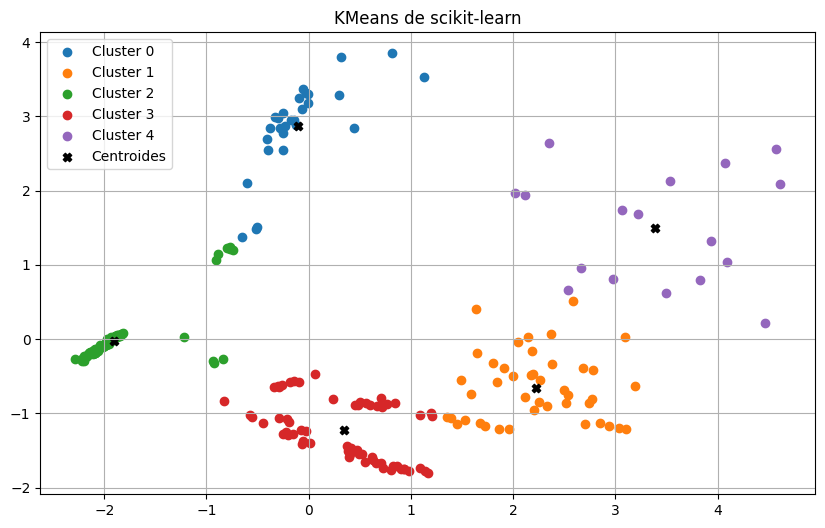

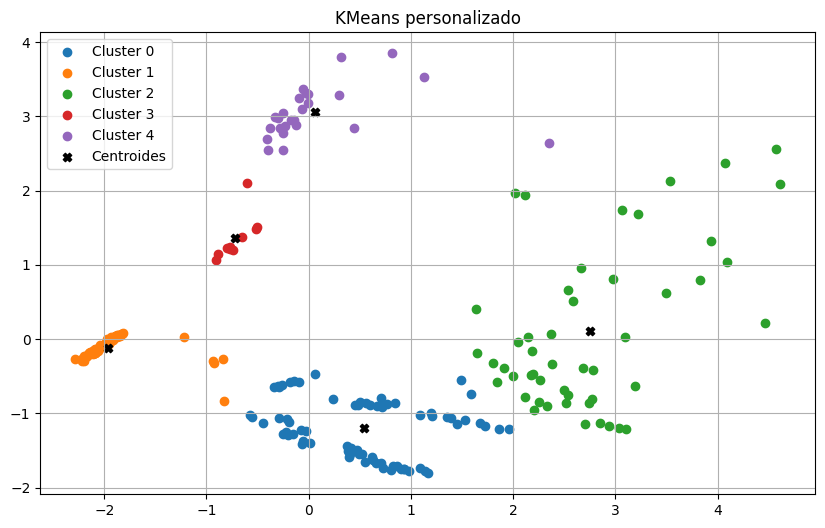

In [124]:
# Escalado de características
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
"""Aquí empieza la implemetación oficial de KMeans de scikit-learn"""
# Clustering con KMeans
start_time = time.time()
kmeans = KMeans(n_clusters=5)
kmeans.fit(data_pca)

# Predicciones de cluster
cluster_labels = kmeans.predict(data_pca)
end_time = time.time()

sklearn_time = end_time - start_time
sk_silhouette = silhouette_score(data_pca, cluster_labels)

# Y lo mostramos en una gráfica.
plt.figure(figsize=(10, 6))
for label in np.unique(cluster_labels):
    plt.scatter(data_pca[cluster_labels == label, 0], data_pca[cluster_labels == label, 1], label=f'Cluster {label}')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', color='black', label='Centroides')

plt.title('KMeans de scikit-learn')
plt.legend()
plt.grid(True)
plt.show()

"""Por último implementamos nuestro propio KMeans, el cual se inicializa de manera similar, pero se llama con la n en minúscula"""
start_time = time.time()
kmeans = Kmeans(n_clusters=5)
kmeans.fit(data_pca)
end_time = time.time()

cluster_labels_local = kmeans.labels_

local_time = end_time - start_time
local_silhouette = silhouette_score(data_pca, cluster_labels_local)

# Mostrando los resultados
plt.figure(figsize=(10, 6))
for label in np.unique(cluster_labels_local):
    plt.scatter(data_pca[cluster_labels_local == label, 0], data_pca[cluster_labels_local == label, 1], label=f'Cluster {label}')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', color='black', label='Centroides')

plt.title('KMeans personalizado')
plt.legend()
plt.grid(True)
plt.show()


### Comparaciones
A simple vista, podemos observar cómo, teniendo ambos 5 centroides para el algortimo, la implementación oficial se decanta por separar la zona inferior derecha en 3 clusters, mientras que nuestra implementación en dos, y por el contrario, compensa separando la zona superior con tres clusters en vez de dos. Sin aplicar ninguna métrica de puntuación, parece que ambas implementaciones son correctas, pero para tener una prueba más solída para comparar ambos métodos, vamos a comparar su tiempo de ejecución y su puntuación usando la silhouette score de métrica


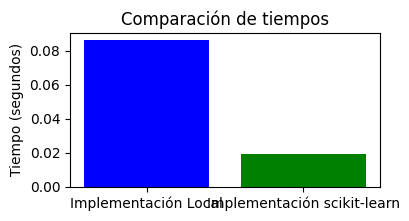

SCORES
Local: 0.6377694148999287	SkLearn: 0.6451947033112416


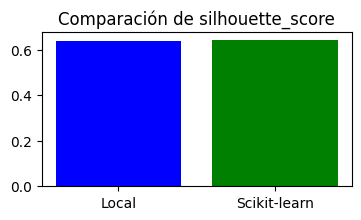

In [125]:
t_names = ['Implementación Local', 'Implementación scikit-learn']

# Valores de los tiempos
times = [local_time, sklearn_time]

# Crear gráfico de barras para los tiempos
plt.figure(figsize=(4,2))
plt.bar(t_names, times, color=['blue', 'green'])

# Agregar título y etiquetas
plt.title('Comparación de tiempos')
plt.ylabel('Tiempo (segundos)')

# Mostrar la gráfica
plt.show()

# Y ahora haremos la comparación con la silhouette score
s_names = ['Local', 'Scikit-learn']

scores = [local_silhouette, sk_silhouette]
print(f"SCORES\nLocal: {local_silhouette}\tSkLearn: {sk_silhouette}")
# Crear gráfico de barras
plt.figure(figsize=(4,2))
plt.bar(s_names, scores, color=['blue', 'green'])
# Agregar título y etiquetas
plt.title('Comparación de silhouette_score')
plt.show()

### Conclusiones

# Comparación de Encoders y de métodos de clustering
Una vez hemos comaprados ambos Kmeans usando usando el mismo método con los datos (ordinal encoder), vamos a comprobar si nuestra decisión fué la correcta, probando ahora con OneHot encoding y con algortimos de clustering como hierchical o DBSCAN.

#### OneHot Encoding VS Ordinal Encoding
Para probar cual es mejor para nuestro conjunto de entrenamiento, usaremos copias de los datos originales y le iremos aplicando todas las posibles combinaciones de ambos encoders, almacenando los resultados para ser posteriormente evaluados por los métodos de clustering.

In [126]:
from itertools import product # Para sacar las combinaciones de OHE y Ordinal

# Para evitar problemas innecesarios, crearemos una copia nueva para los datos y trabajaremos sobre ella
data = pd.read_csv('Stars2.csv')
# Dado que los problemas de mapeo vuelven a surgir, será necesario volver a normalizar el color
mapping = {
    "Red": ["Red"],
    "Orange-Red": ["Orange-Red"],
    "Orange": ["Orange"],
    "Yellow-Orange": ["Pale yellow orange"],
    "Yellow": ["yellowish", "Yellowish"],
    "White-Yellow": ["Yellowish White", "yellow-white", "White-yellow"],
    "White": ["White", "Whitish", "white"],
    "Blue-white": ["Blue-White", "Blue-white", "Blue White", "Blue white"],
    "Blue": ["Blue"]
}
normalized_colors = list(mapping.keys())

data['Color'] = data['Color'].apply(lambda x: next((k for k, v in mapping.items() if x in v), x))
spectrum = ['O', 'B', 'A', 'F', 'G', 'K', 'M']

# Lista para almacenar los resultados
master_data = []

# Iterar sobre todas las combinaciones de codificación para color y clase espectral
for color_encoding, spectral_encoding in product(['O', 'H'], repeat=2):
    df = data.copy()
    
    # Codificación ordinal de color
    if color_encoding == 'O':
        color_encoder = OrdinalEncoder(categories=[normalized_colors])
        df['Color_Encoded'] = color_encoder.fit_transform(df[['Color']])
    else:
        color_encoder = OneHotEncoder(categories=[normalized_colors])
        color_encoded = color_encoder.fit_transform(df[['Color']])
        color_encoded_df = pd.DataFrame(color_encoded.toarray(), columns=[f'Color_{i}' for i in range(1, 10)])
        df = pd.concat([df, color_encoded_df], axis=1)
    
    # Codificación ordinal de clase espectral
    if spectral_encoding == 'O':
        spectral_encoder = OrdinalEncoder(categories=[spectrum])
        df['Spectral_Class_Encoded'] = spectral_encoder.fit_transform(df[['Spectral_Class']])
    else:
        spectral_encoder = OneHotEncoder(categories=[spectrum])
        spectral_encoded = spectral_encoder.fit_transform(df[['Spectral_Class']])
        spectral_encoded_df = pd.DataFrame(spectral_encoded.toarray(), columns=[f'Spectral_Class_{i}' for i in range(1, 8)])
        df = pd.concat([df, spectral_encoded_df], axis=1)
    
    # Eliminar las columnas originales de color y clase espectral
    df.drop(['Color', 'Spectral_Class'], axis=1, inplace=True)
    
    # Agregar la tupla a master_data
    master_data.append((color_encoding, spectral_encoding, df))



#### KMeans VS Hierchical VS DBSCAN
Ahora que ya tenemos almacenadas todas las psoibles combinaciones para converitr los datos catergóricos, vamos a usar los métodos de clustering para encontrar la mejor combinación para el problema.

Data Combination: Color Encoding - O, Spectral Encoding - O


 ##### Clustering Algorithm: KMeans #####
Color: O && Spectral: O
La mejor puntuación = 0.6887562212534886
 Los mejores parámetos = {'init': 'k-means++', 'max_iter': 200, 'n_clusters': 5, 'tol': 0.01}


 ##### Clustering Algorithm: Hierarchical Clustering #####
Color: O && Spectral: O
La mejor puntuación = 0.6811265694682159
 Los mejores parámetos = {'compute_distances': True, 'compute_full_tree': True, 'distance_threshold': None, 'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 5}


 ##### Clustering Algorithm: DBSCAN #####
Color: O && Spectral: O
La mejor puntuación = 0.6815710464335907
 Los mejores parámetos = {'eps': 0.1, 'metric': 'cosine', 'min_samples': 2}


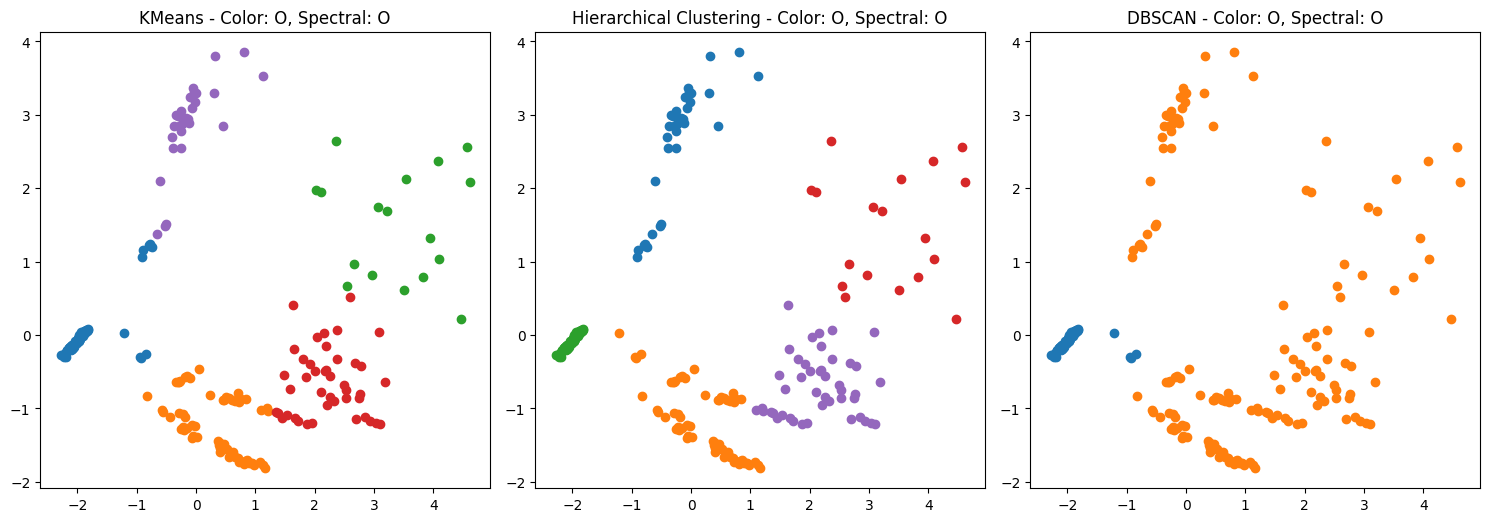



Data Combination: Color Encoding - O, Spectral Encoding - H


 ##### Clustering Algorithm: KMeans #####
Color: O && Spectral: H
La mejor puntuación = 0.730311645743239
 Los mejores parámetos = {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 5, 'tol': 0.001}


 ##### Clustering Algorithm: Hierarchical Clustering #####
Color: O && Spectral: H
La mejor puntuación = 0.7340465526772901
 Los mejores parámetos = {'compute_distances': True, 'compute_full_tree': True, 'distance_threshold': None, 'linkage': 'average', 'metric': 'euclidean', 'n_clusters': 5}


 ##### Clustering Algorithm: DBSCAN #####
Color: O && Spectral: H
La mejor puntuación = 0.7320754203296818
 Los mejores parámetos = {'eps': 0.1, 'metric': 'cosine', 'min_samples': 5}


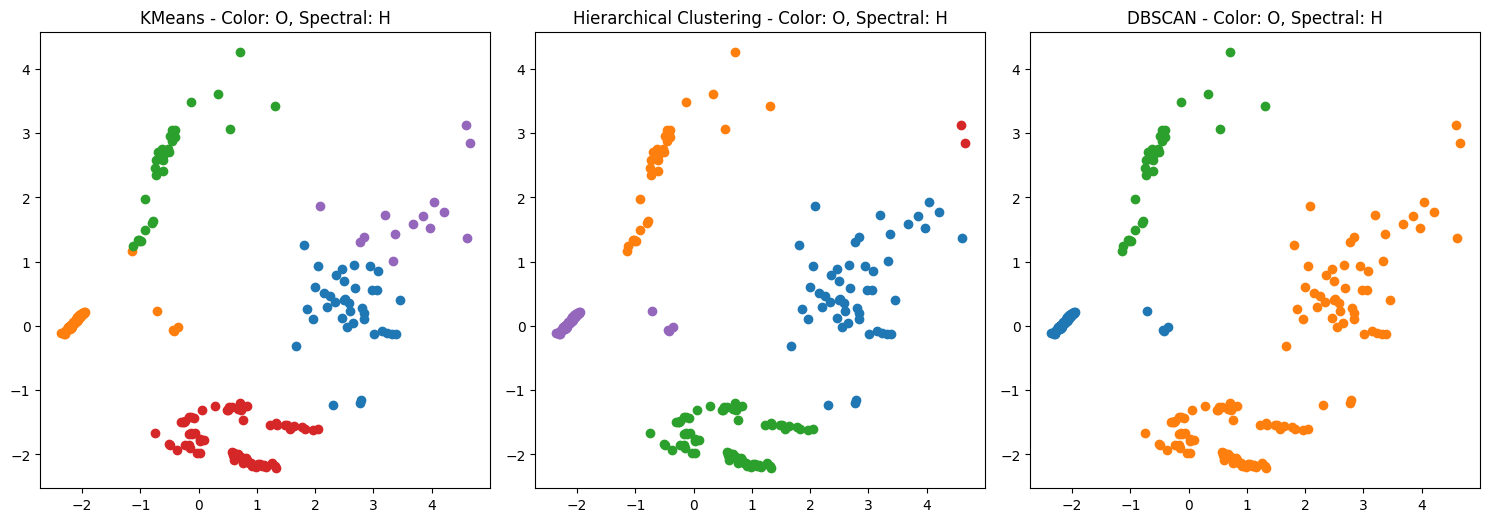



Data Combination: Color Encoding - H, Spectral Encoding - O


 ##### Clustering Algorithm: KMeans #####
Color: H && Spectral: O
La mejor puntuación = 0.7181626352154075
 Los mejores parámetos = {'init': 'k-means++', 'max_iter': 200, 'n_clusters': 5, 'tol': 0.001}


 ##### Clustering Algorithm: Hierarchical Clustering #####
Color: H && Spectral: O
La mejor puntuación = 0.713649647503033
 Los mejores parámetos = {'compute_distances': True, 'compute_full_tree': True, 'distance_threshold': None, 'linkage': 'complete', 'metric': 'manhattan', 'n_clusters': 5}


 ##### Clustering Algorithm: DBSCAN #####
Color: H && Spectral: O
La mejor puntuación = 0.6984737456618513
 Los mejores parámetos = {'eps': 1.0, 'metric': 'euclidean', 'min_samples': 2}


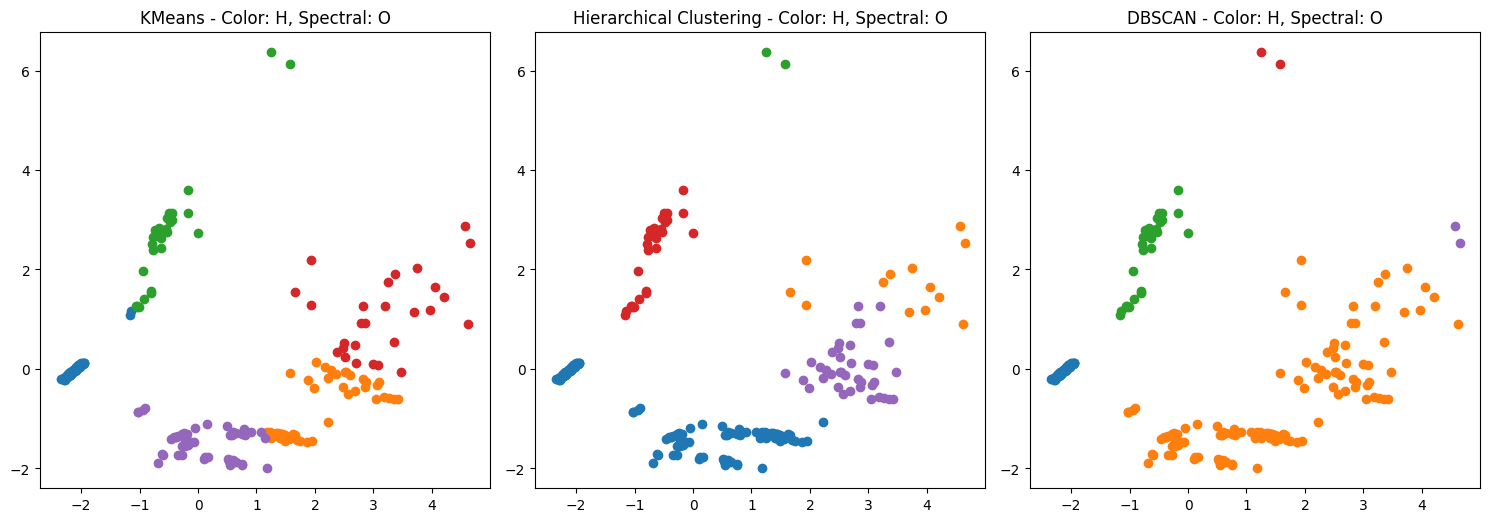



Data Combination: Color Encoding - H, Spectral Encoding - H


 ##### Clustering Algorithm: KMeans #####
Color: H && Spectral: H
La mejor puntuación = 0.7384666856363954
 Los mejores parámetos = {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 5, 'tol': 0.001}


 ##### Clustering Algorithm: Hierarchical Clustering #####
Color: H && Spectral: H
La mejor puntuación = 0.7333663060804911
 Los mejores parámetos = {'compute_distances': True, 'compute_full_tree': True, 'distance_threshold': None, 'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 5}


 ##### Clustering Algorithm: DBSCAN #####
Color: H && Spectral: H
La mejor puntuación = 0.745267065114402
 Los mejores parámetos = {'eps': 1.0, 'metric': 'euclidean', 'min_samples': 2}


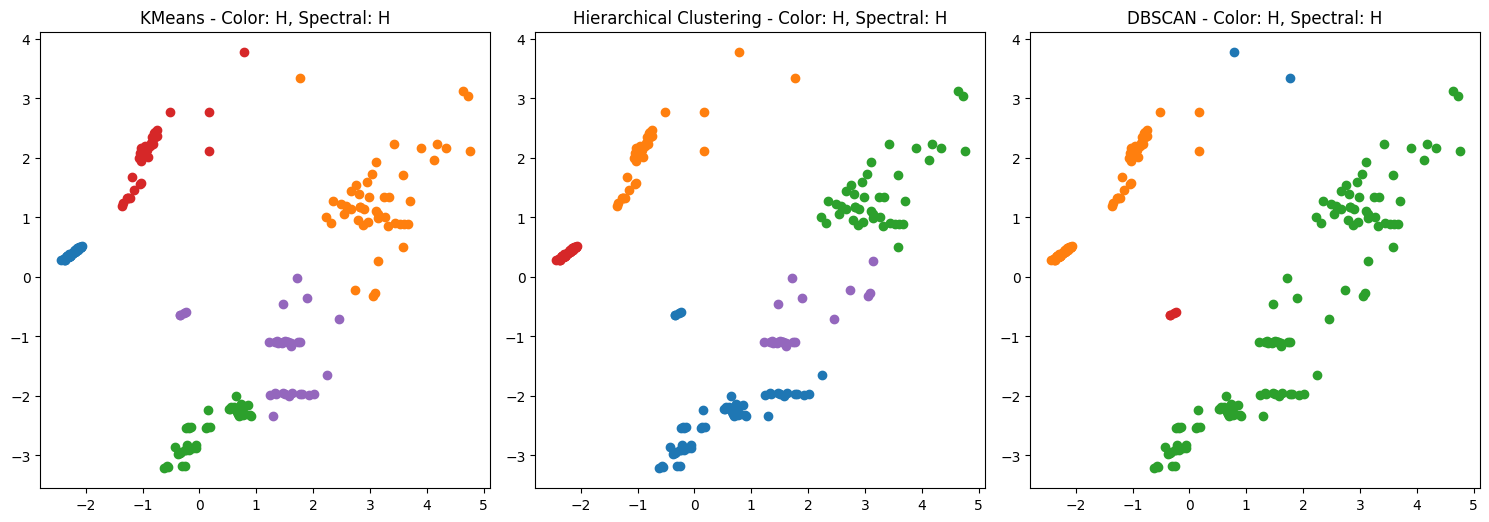

In [127]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score


param_grid_kmeans = {
    'n_clusters': [5, 6, 7, 8] ,
    'init': ['k-means++', 'random'],
    'max_iter': [100, 200, 300],
    'tol': [1e-4, 1e-3, 1e-2]
}

param_grid_hierarchical = {
    'compute_distances': [True, False],
    'compute_full_tree': [True, False],
    'distance_threshold': [None, 1.0, 2.0],  
    'linkage': ['ward', 'complete', 'average', 'single'],
    'metric': ['euclidean', 'manhattan', 'cosine'],  
    'n_clusters': [5, 6, 7, 8] 
}


param_grid_dbscan = {
    'eps': [0.1, 0.5, 1.0],
    'min_samples': [2, 5, 10],
    'metric': ['euclidean', 'manhattan', 'cosine']
}

# Definir la métrica de evaluación
#scoring = 'adjusted_rand_score'

def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    if len(np.unique(labels)) > 1:
        return silhouette_score(X, labels)
    else:
        return np.nan


# Definir una lista de algoritmos de clustering
clustering_algorithms = {
    "KMeans": (KMeans(), param_grid_kmeans),
    "Hierarchical Clustering": (AgglomerativeClustering(), param_grid_hierarchical),
    "DBSCAN": (DBSCAN(), param_grid_dbscan)
}

scores = {}


# Aplicar StandardScaler y PCA a todas las combinaciones de datos
for color_encoding, spectral_encoding, df in master_data:
    subplot_index = 1

    print(f"Data Combination: Color Encoding - {color_encoding}, Spectral Encoding - {spectral_encoding}")
    
    # Aplicar StandardScaler
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    
    # Aplicar PCA con 2 componentes
    pca = PCA(n_components=2)
    df_pca = pca.fit_transform(df_scaled)
    
    plt.figure(figsize=(15, 15))

    
    for algorithm_name, algorithm in clustering_algorithms.items():
        print(f"\n\n ##### Clustering Algorithm: {algorithm_name} #####")
        
        grid_search = GridSearchCV(algorithm[0], algorithm[1], scoring=silhouette_scorer, n_jobs=-1)
        # Realizar clustering con el algoritmo actual
        grid_search.fit(df_pca)
        
        best_score = grid_search.best_score_
        best_params = grid_search.best_params_
        print(f"Color: {color_encoding} && Spectral: {spectral_encoding}")
        print(f"La mejor puntuación = {best_score}\n Los mejores parámetos = {best_params}")
        scores[(algorithm_name, color_encoding, spectral_encoding)] = best_score

        # Mostrar los resultados de los clusters
        best_estimator = grid_search.best_estimator_
        cluster_labels = best_estimator.labels_
        unique_labels = np.unique(cluster_labels)
    
        plt.subplot(3, 3, subplot_index)

        plt.title(f'{algorithm_name} - Color: {color_encoding}, Spectral: {spectral_encoding}')
        
        for label in unique_labels:
            plt.scatter(df_pca[cluster_labels == label, 0], df_pca[cluster_labels == label, 1], label=f'Cluster {label}')
        
        subplot_index += 1

    plt.tight_layout()
    plt.show()
    
    print("\n")






Data Combination: Color Encoding - O, Spectral Encoding - O
Best parameters: {'init': 'random', 'max_iter': 100, 'n_clusters': 5, 'tol': 0.001}
Best silhouette score: 0.6893173298943531
Data Combination: Color Encoding - O, Spectral Encoding - H
Best parameters: {'init': 'random', 'max_iter': 200, 'n_clusters': 5, 'tol': 0.0001}
Best silhouette score: 0.7313750827273535
Data Combination: Color Encoding - H, Spectral Encoding - O
Best parameters: {'init': 'k-means++', 'max_iter': 200, 'n_clusters': 5, 'tol': 0.01}
Best silhouette score: 0.7202982067871528
Data Combination: Color Encoding - H, Spectral Encoding - H
Best parameters: {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 5, 'tol': 0.0001}
Best silhouette score: 0.7325163315202025


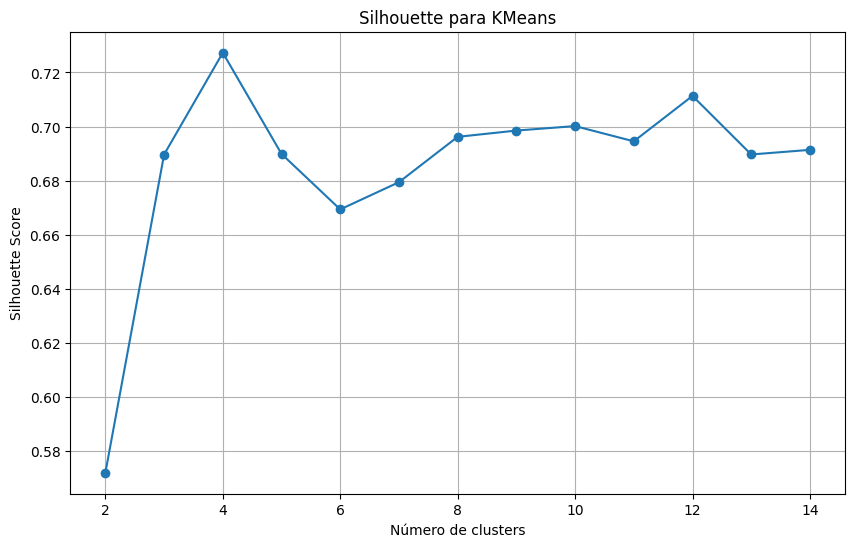

In [128]:


# Aplicar StandardScaler y PCA a todas las combinaciones de datos
for color_encoding, spectral_encoding, df in master_data:
    print(f"Data Combination: Color Encoding - {color_encoding}, Spectral Encoding - {spectral_encoding}")
    
    # Aplicar StandardScaler
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    
    # Aplicar PCA con 2 componentes
    pca = PCA(n_components=2)
    df_pca = pca.fit_transform(df_scaled)

    
    ## Hacer un Kmeans con un siluette score usando los datos de arriba, los encodados, los 4 OO, OH, HO y HH
    # Y de ahí, sacar el mejor valor, y es lo que usarmoes para los clusters. 
    grid_search = GridSearchCV(KMeans(), param_grid_kmeans, scoring=silhouette_scorer, n_jobs=-1)
    grid_search.fit(df_pca)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best silhouette score: {grid_search.best_score_}")
        


# Con estos datos, podemos ver que el mejor es :
"""
Data Combination: Color Encoding - H, Spectral Encoding - H
Algorithm: KMeans
Best parameters: {'init': 'random', 'max_iter': 300, 'n_clusters': 5, 'tol': 0.01}
Best silhouette score: 0.7333663060804909
"""
# Por lo que utilizaremos un Kmeans con 5 clusters, con los datos de Color Encoding - O, Spectral Encoding - H


# Ahora vamos a hacer el método del codo con los dos algorithmos, KMenas y Hierarchical Clustering
# Vamos a ver el scoring con diferentes valores de clusters
scores = []
for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=472175)
    kmeans.fit(df_pca)
    scores.append(silhouette_score(df_pca, kmeans.labels_))

plt.figure(figsize=(10, 6))
plt.plot(range(2, 15), scores, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette para KMeans')
plt.grid(True)
plt.show()

    

    ## Problema: Está basada en que el Kmeans puede trabajar mejor con esas configuraciones, pero puede que otros algoritmos no.
    

# Conclusiones Finales